# Classifying Documents

In this notebook we demonstrate a basic document level classification of reports with respect to a single finding ( fever). We leverage the convenience of Pandas to read our data from a SQLite database and then use Pandas to add our classification as a new column in the dataframe.

Many of the common pyConTextNLP tasks have been wrapped into functions contained in the [``radnlp``](https://github.com/chapmanbe/RadNLP) pacakge. We important multiple modules that will allow us to write concise code.

In [1]:
import radnlp

In [7]:
import pyConTextNLP.pyConTextGraph as pyConText
import pyConTextNLP.itemData as itemData
import os
import radnlp.io  as rio
import radnlp.view as rview
import radnlp.rules as rules
import radnlp.schema as schema
import radnlp.utils as utils
import radnlp.split as split
import radnlp.classifier as classifier
import sqlite3 as sq
import pandas as pd
from IPython.display import clear_output, display, HTML, Image
from IPython.html.widgets import interact, interactive, fixed
from IPython.display import clear_output
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
from radnlp.data import classrslts 
import networkx as nx

In [8]:
colors={"pulmonary_embolism":"blue",
       "definite_negated_existence":"red",
       "probable_negated_existence":"indianred",
       "ambivalent_existence":"orange",
       "probable_existence":"forestgreen",
       "definite_existence":"green",
       "historical":"goldenrod",
       "indication":"Pink",
       "acute":"golden"}

In [9]:
import radnlp
radnlp.__version__

'0.2.0.8'

### Explanation of ``getOptions``

This is just kind of a port of a command line application where I'd use argparse to get the options.


In [15]:
def getOptions():
    """Generates arguments for specifying database and other parameters"""
    options = {}
    options['infile'] = os.path.join("pitt_reports.sqlite")
    options['lexical_kb'] = ["https://raw.githubusercontent.com/chapmanbe/pyConTextNLP/master/KB/lexical_kb_05042016.tsv"]
    options['domain_kb'] = ["https://raw.githubusercontent.com/chapmanbe/pyConTextNLP/master/KB/pe_kb.tsv"]
    options["schema"] = "https://raw.githubusercontent.com/chapmanbe/pyConTextNLP/master/KB/schema2.csv"
    options["rules"] = "https://raw.githubusercontent.com/chapmanbe/pyConTextNLP/master/KB/classificationRules3.csv" 
    return options

#### Explation of ``get_kb_rules_schema``

* ``itemData.instantiateFromCSVtoitemData``: This function is a somewhat unfortunate name as it implies reading CSV files but we've moved to tab delimited files, since we sometimes have commas in the regular expressions.


In [16]:
def get_kb_rules_schema(options):
    """
    Get the relevant kb, rules, and schema.
    
    """
    _radnlp_rules = rules.read_rules(options["rules"])
    _schema = schema.read_schema(options["schema"])
    
    modifiers = itemData.itemData()
    targets = itemData.itemData()
    for kb in options['lexical_kb']:
        modifiers.extend( itemData.instantiateFromCSVtoitemData(kb) )
    for kb in options['domain_kb']:
        targets.extend( itemData.instantiateFromCSVtoitemData(kb) )
    return {"rules":_radnlp_rules,
            "schema":_schema,
            "modifiers":modifiers,
            "targets":targets}
    

In [17]:
def analyze_report(report, modifiers, targets, rules, schema):
    """
    given an individual radiology report, creates a pyConTextGraph
    object that contains the context markup
    report: a text string containing the radiology reports
    """
    markup = utils.mark_report(split.get_sentences(report),
                         modifiers,
                         targets)
    
    clssfy =   classifier.classify_document_targets(markup,
                                          rules[0],
                                          rules[1],
                                          rules[2],
                                          schema)
    return classrslts(context_document=markup, exam_type="ctpa", report_text=report, classification_result=clssfy)

#### Alternatively, do each step separately

In [18]:

def mark_report(report, modifiers, targets):
    """
    given an individual radiology report, creates a pyConTextGraph
    object that contains the context markup
    report: a text string containing the radiology reports
    """
    
    markup = utils.mark_report(split.get_sentences(report),
                         modifiers,
                         targets)
    return markup
def classify_report(markup, rules, schema):

    return  classifier.classify_document_targets(markup,
                                          rules[0],
                                          rules[1],
                                          rules[2],
                                          schema)

In [19]:
def get_data():
    options = getOptions()
    kb = get_kb_rules_schema(options)
    conn = sq.connect(options['infile'])
    data = pd.read_sql("""SELECT * FROM reports""", conn)
    return data, kb



In [20]:
data, kb = get_data()
#data = data.dropna()

In [21]:
from collections import defaultdict

utahData = defaultdict(lambda: defaultdict(list))

for index, row in data.iterrows():
    if(row['disease_state']!=None and row['disease_state']!='NULL' ):
        utahData['disease_state']['text'].append(row['impression'])
        utahData['disease_state']['label'].append(row['disease_state'])
    if(row['uncertainty']!=None and row['uncertainty']!='NULL'):
        utahData['uncertainty']['text'].append(row['impression'])
        utahData['uncertainty']['label'].append(row['uncertainty'])
    if(row['quality']!=None and row['quality']!='NULL'):
        utahData['quality']['text'].append(row['impression'])
        utahData['quality']['label'].append(row['quality'])
    if(row['historicity']!=None and row['historicity']!='NULL'):
        utahData['historicity']['text'].append(row['impression'])
        utahData['historicity']['label'].append(row['historicity'])

### Document Classification

We now need to apply our schema to the reports. Since our data is in a Pandas data frame, the easiest way to process our reports is with the DataFrame [``apply``](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) method.

* We use ``lambda`` to create an anonymous function which basically just applies ``analyze_report`` to the ``"impression"`` column with the modifiers, targets, etc. that we have read in separately.
* ``analyze_report`` returns a dictionary with ``keys`` as any identified targets defined in the ``"targets"`` file and values as a tuple with values:
    * The schema value that was selected for the document
    * The node (evidence) that was used for selecting that schema value
    

In [22]:
data = data.dropna(subset=['impression'])

In [24]:
data["pe rslt"] = \
data.apply(lambda x: analyze_report(x["impression"], 
                                     kb["modifiers"], 
                                     kb["targets"],
                                     kb["rules"],
                                     kb["schema"]), axis=1)

In [25]:
data['pe rslt']

0      (__________________________________________\n,...
1      (__________________________________________\n,...
2      (__________________________________________\n,...
3      (__________________________________________\n,...
4      (__________________________________________\n,...
5      (__________________________________________\n,...
6      (__________________________________________\n,...
7      (__________________________________________\n,...
8      (__________________________________________\n,...
9      (__________________________________________\n,...
10     (__________________________________________\n,...
11     (__________________________________________\n,...
12     (__________________________________________\n,...
13     (__________________________________________\n,...
14     (__________________________________________\n,...
15     (__________________________________________\n,...
16     (__________________________________________\n,...
17     (_______________________

In [26]:
data = data.dropna(subset=['impression'])

In [27]:
data['pe rslt'][0].classification_result

{'pulmonary_embolism': (2,
  "\n<tagObject>\n<id> 316086769872931135050070934333676388355 </id>\n<phrase> PULMONARY EMBOLISM </phrase>\n<literal> pulmonary embolism </literal>\n<category> ['pulmonary_embolism'] </category>\n<spanStart> 3 </spanStart>\n<spanStop> 21 </spanStop>\n<scopeStart> 0 </scopeStart>\n<scopeStop> 22 </scopeStop>\n</tagObject>\n",
  [])}

In [28]:
data["pe rslt"][1].classification_result

{'pulmonary_embolism': (8,
  "\n<tagObject>\n<id> 316097002190119852289271140534862282755 </id>\n<phrase> PULMONARY EMBOLISM </phrase>\n<literal> pulmonary embolism </literal>\n<category> ['pulmonary_embolism'] </category>\n<spanStart> 34 </spanStart>\n<spanStop> 52 </spanStop>\n<scopeStart> 0 </scopeStart>\n<scopeStop> 166 </scopeStop>\n</tagObject>\n",
  [])}

In [29]:
data["pe rslt"][2].classification_result

{'pulmonary_embolism': (8,
  "\n<tagObject>\n<id> 316105165067703696943973403368065400835 </id>\n<phrase> PULMONARY EMBOLISM </phrase>\n<literal> pulmonary embolism </literal>\n<category> ['pulmonary_embolism'] </category>\n<spanStart> 78 </spanStart>\n<spanStop> 96 </spanStop>\n<scopeStart> 0 </scopeStart>\n<scopeStop> 97 </scopeStop>\n</tagObject>\n",
  [])}

In [30]:
data

,id,impression,disease_state,uncertainty,quality,historicity,pe rslt
0,70,\n[Report de-identified (Limited dataset compl...,Neg,No,Diagnostic,None,"(__________________________________________\n,..."
1,71,\n[Report de-identified (Limited dataset compl...,Pos,No,Diagnostic,New,"(__________________________________________\n,..."
2,72,\n[Report de-identified (Limited dataset compl...,Pos,Yes,Diagnostic,New,"(__________________________________________\n,..."
3,73,\n[Report de-identified (Limited dataset compl...,Neg,No,Diagnostic,None,"(__________________________________________\n,..."
4,74,\n[Report de-identified (Limited dataset compl...,Neg,Yes,Not Diagnostic,None,"(__________________________________________\n,..."
5,75,\n[Report de-identified (Limited dataset compl...,Pos,No,Diagnostic,New,"(__________________________________________\n,..."
6,76,\n[Report de-identified (Limited dataset compl...,Pos,No,Diagnostic,New,"(__________________________________________\n,..."
7,77,\n[Report de-identified (Limited dataset compl...,Neg,Yes,Diagnostic,None,"(__________________________________________\n,..."
8,78,\n[Report de-identified (Limited dataset compl...,Neg,No,Diagnostic,None,"(__________________________________________\n,..."
9,79,\n[Report de-identified (Limited dataset compl...,Pos,Yes,Not Diagnostic,New,"(__________________________________________\n,..."


In [31]:
def view_markup(reports, colors):
    @interact(i=widgets.IntSlider(min=0, max=len(reports)-1))
    def _view_markup(i):
        markup = reports["pe rslt"][i]
        rview.markup_to_pydot(markup)
        display(Image("tmp.png"))
        mt = rview.markup_to_html(markup, color_map=colors)

        display(HTML(mt))

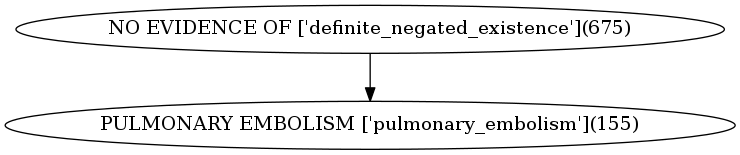

report,classification
"[Report de-identified (Limited dataset compliant) by De-ID v.6.21.01.0] 1. LIMITED STUDY, NO EVIDENCE OF A CENTRAL PULMONARY EMBOLISM. 2. MODERATE LEFT-SIDED PLEURAL EFFUSION WITH LEFT LOWER LOBE CONSOLIDATION WORRISOME FORPNEUMONIA IN THE PROPER CLINICALSETTING. 3. FOLLOW UP CTA OR VQ SCAN COULD BE OBTAINED FOR FURTHEREVALUATION. My signature below is attestation that I have interpreted this/these examination(s) and agree with the findings as notedabove. END OF IMPRESSION: NULL",pulmonary_embolism (Negative/Certain/Acute)


In [34]:
view_markup(data, colors)

## Known Issues

### pyConTextNLP does not deal with coreference
#### Example: Report 776
* Since we deal with each sentence independently, we miss the historical modifiers in the subsequent sentences
* graphviz does not seem to draw directional graphs with single nodes
* The ``radnlp`` package is very rough and I'll be working on it extensively.
